# 房价预测_V1 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']

通过分析可以发现：
* 训练集和测试机分别有1460个样本。
* 一共81种属性，其中36个是标量，43个是类目化的，另外还有Id以及售价SalePrice

## 查看缺失情况

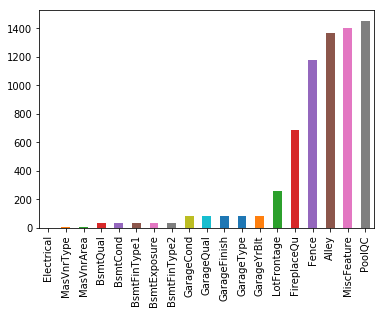

In [3]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar()

有19种属性存在缺失值。
大多数时候缺失表明房子没有相关的配备，例如pool、fense、garage或者basement.

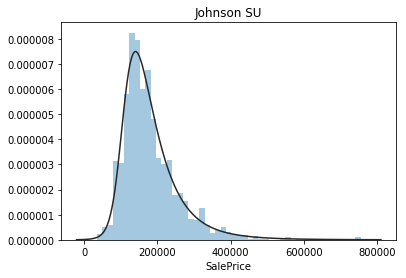

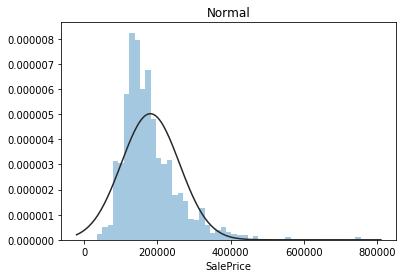

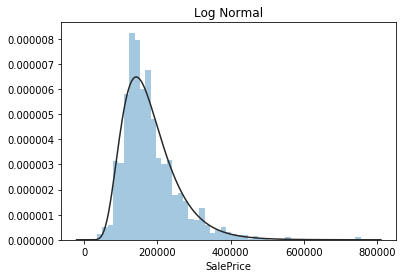

In [8]:
y = train['SalePrice']
plt.figure(1);
plt.title('Johnson SU')
sns.distplot(y, kde = False, fit = st.johnsonsu)
plt.figure(2);
plt.title("Normal")
sns.distplot(y, kde = False, fit = st.norm)
plt.figure(3);
plt.title('Log Normal')
sns.distplot(y, kde = False, fit = st.lognorm)

很明显SalePrice不符合正态分布，所以在进行回归之前需要进行转换。
同时对数转换表现良好，最匹配的是Johnson

In [13]:
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


这样训练集中的标量变量也不满足正态分布，也需要进行转换

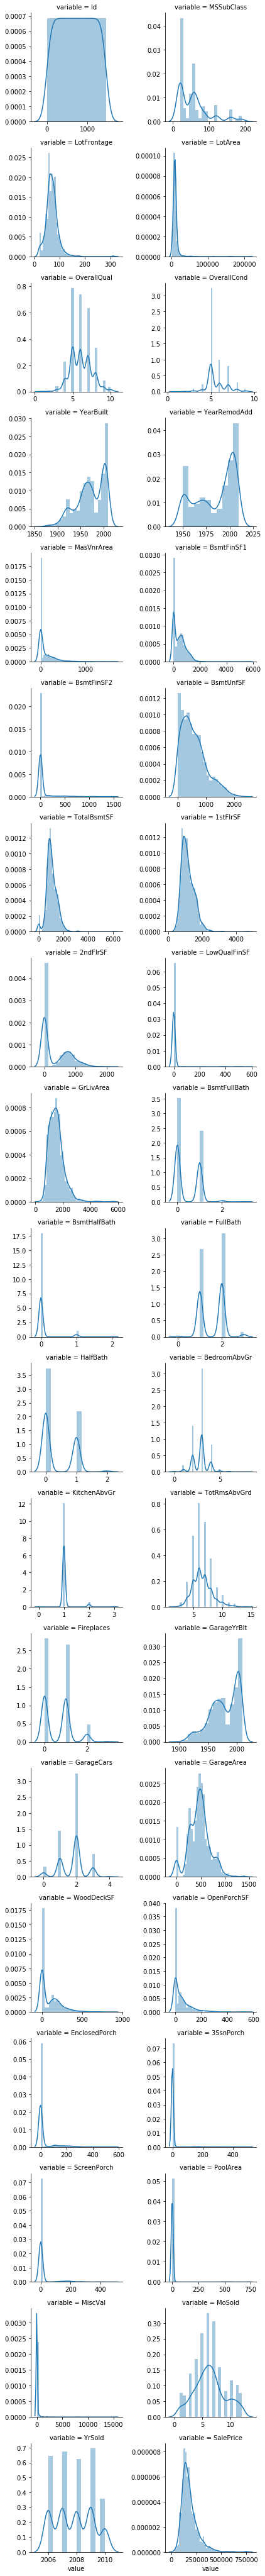

In [14]:
f = pd.melt(train, value_vars = quantitative)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 2, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")